In [2]:
# Load results
import os
import pandas as pd

results = pd.DataFrame()
results_path = "./results/extraction/topic_shift/"
result_file_list = os.listdir(results_path)
for filename in result_file_list:
    df = pd.read_csv(results_path + filename, names = ["filename", "turn", "full_summary", "omitted_summary", "similarity"])
    results = pd.concat([results, df])


In [3]:
# Cast dtype
results = results.astype({"similarity": float, "turn": int})

results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1264 entries, 0 to 12
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         1264 non-null   int64  
 1   turn             1264 non-null   int64  
 2   full_summary     1264 non-null   object 
 3   omitted_summary  1264 non-null   object 
 4   similarity       1264 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 59.2+ KB


In [4]:
# Remove duplicates
results = results.drop_duplicates(subset=["filename", "turn"], keep="last")

#print(results)

Text(0, 0.5, 'Frequency')

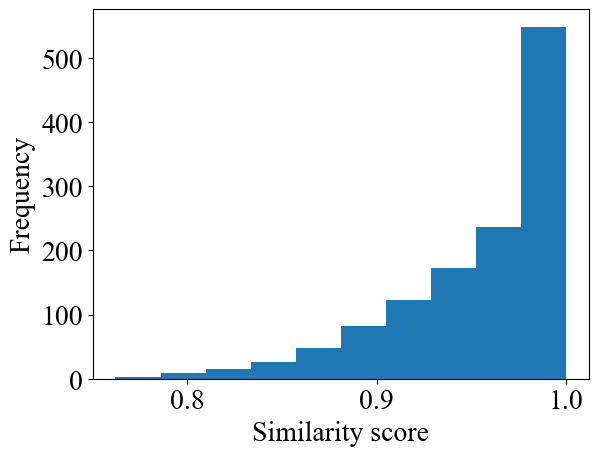

In [5]:
# Show histogram
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"   # 使用するフォント
plt.rcParams["font.size"] = 20                 # 文字の大きさ

hist = plt.hist(results["similarity"])
plt.xlabel("Similarity score")
plt.ylabel("Frequency")

In [5]:
# Sort by similarity
results = results.sort_values("similarity")
#results = results.reset_index()

#print(results)

In [7]:
# Show top and bottom
import json

def show_row(row, dataset):
    data = dataset[str(row.filename)]
    dialogue = [r[0] for r in data]
    full_dialogue = "\n".join(dialogue[:row.turn + 1])
    print("-----------------")
    print("filename")
    print(row.filename)
    print("full dialogue")
    print(full_dialogue)
    print("full summary")
    print(row.full_summary)
    print("omitted summary")
    print(row.omitted_summary)
    print("similarity") 
    print(row.similarity)
    return

with open("./dat/TIAGE/anno_test.json") as f:
    dataset = json.load(f)


NUM_EXAMPLES = 5
for row in results.head(NUM_EXAMPLES).itertuples():
    show_row(row, dataset)

for row in results.tail(NUM_EXAMPLES).itertuples():
    show_row(row, dataset)



-----------------
filename
30
full dialogue
how are you today ? i like you
i am great . just relaxing and knitting some hats for the babies at my old job .
where did you use to work ?
childrens hospital until i became disabled . what do you do ?
i rent out houses to people
that is a great industry . what kind of music do you like ?
like people who are handy ?
full summary
What kind of music do you enjoy listening to?
omitted summary
Do you have a preference for individuals who are skilled at fixing things?
similarity
0.7623483738357362
-----------------
filename
33
full dialogue
hello how are you ?
i am fine shopping for clothes wyd ?
what kind of clothes ? i am just playing with ginger my golden retriever
i like jeans an boots
what is your favorite store ? i did not shop at all when i studied abroad
amazon is my favorite store , you cannot go wrong .
do you not worry about trying on clothes first ? i buy model cards from there
no i pick pretty well trust me
do you have any kids ? i ju

In [6]:
# Count number of sentences similarity < 0.9
threshold = 0.85
under_threshold = results["similarity"] < threshold
n_under_threshold = under_threshold.sum()
print(n_under_threshold)
results_under_threshold = results[under_threshold]
bottom_results = results_under_threshold.reset_index()

42


In [8]:
# Load topic shift data
import json

with open("./dat/TIAGE/anno_test.json") as f:
    dataset = json.load(f)


In [11]:
# Combine similarity and importance
combined_data = pd.DataFrame(
    columns=["filename", "turn", "utterance", "scain", "topic_shift"]
)

n_dialogue = 100
threshold = 0.85

for idx_dialogue in range(1, n_dialogue + 1):
    str_idx = str(idx_dialogue)
    data = dataset[str_idx]

    dialogue = [r[0] for r in data]
    topic_anno = [r[1] for r in data]

    for idx_utterance, utterance in enumerate(dialogue):
        summary_row = results.query(
            "filename == @idx_dialogue and (turn == @idx_utterance + 1 or turn == @idx_utterance + 2)"
        )
        if len(summary_row.query("similarity < @threshold")) > 0:
            int_low_similarity = 1
        else:
            int_low_similarity = 0

        int_topic = int(topic_anno[idx_utterance])
        # -1: unavailable
        # 0: not topic shift
        # 1: topic shift

        if int_topic >= 0:
            new_data = pd.DataFrame({
                "filename": [idx_dialogue],
                "turn": [idx_utterance + 1],
                "utterance": [utterance],
                "scain": [int_low_similarity],
                "topic_shift": [int_topic]
            })
            combined_data = pd.concat([combined_data, new_data])

print(combined_data)



   filename turn                                          utterance scain  \
0         1    2  i am well an loving this interaction how are y...     0   
0         1    3       i am great . i just got back from the club .     0   
0         1    4   this is my favorite time of the year season wise     0   
0         1    5  i would rather eat chocolate cake during this ...     0   
0         1    6  what club did you go to ? me an timothy watche...     0   
..      ...  ...                                                ...   ...   
0       100   12          i could ! i just wish i could afford it .     0   
0       100   13                           what are you afraid of ?     0   
0       100   14    i am afraid of not being able to pay my bills .     0   
0       100   15     carnival is always hiring , maybe second job ?     0   
0       100   16  maybe , i might have to if things do not start...     0   

   topic_shift  
0            0  
0            0  
0            1  
0      

In [12]:
# Save as CSV
for dialogue_idx in range(1, n_dialogue + 1):
    dialogue_filename = "PP" + str(dialogue_idx) + ".txt"
    sample_data = combined_data.query("filename == @dialogue_filename")
    csv_filename = "./tmp/combined" + str(dialogue_idx) + ".csv"
    sample_data.to_csv(csv_filename)

In [12]:
# Show cross table
crossed = pd.crosstab(combined_data["scain"], combined_data["topic_shift"])
print(crossed)

topic_shift     0    1
scain                 
0            1083  297
1              66   18


In [13]:
# Chi-square test
import scipy as sp
import scipy.stats

chi2_stats = sp.stats.chi2_contingency(crossed)
print(chi2_stats)

Chi2ContingencyResult(statistic=0.0, pvalue=1.0, dof=1, expected_freq=array([[1083.07377049,  296.92622951],
       [  65.92622951,   18.07377049]]))


In [7]:
# List important SCAINs
important_scain = combined_data.query("low_similarity == 1 and important ==1")
print(important_scain)

   filename turn                                          utterance  \
0   PP5.txt    8  B: 寒い時は特に体が硬くなったりしますからね。私は今整体師をしているんですが、そう言う方は...   
0   PP6.txt    4  B: そうですね。私はＡ型の１２月、しかも大晦日生まれなんですが、両方の占いを総合してみると...   
0   PP6.txt   10                B: 整体師さんなんですね。私は肩がこるので、時々整体に行っています。   
0   PP9.txt    9          A: そうですね。好きなことをして過ごすことで、気持ちも段々晴れてくると思います。   
0  PP11.txt    4                   B: かっこいいですね。実は早起きが苦手で朝練が辛いんですよね。   
0  PP13.txt   10  B: 漫画も面白いですよね、勉強になりますし。ところでご結婚されているんですか？わたしは好き...   
0  PP26.txt    2   B: DIYなんて、すごいじゃないですか！私は滋賀で開業医を営んでいますが、趣味はゴルフですね。   
0  PP38.txt   10  B: ええ、あとでね。ところで質問なんですけど、もし痩せることができたら、あなたはまた神を信...   
0  PP40.txt    7  A: 緊張なんてしなくていいのに！わたしが住んでる田舎なんて初対面なのにみんな親戚みたいに声...   
0  PP42.txt    9  A: 本当だね。よかったらお友達にならない？わたし趣味で手芸をやってるんだけど一緒にやってみない？   
0  PP44.txt    9  A: 大学生で株をやってるなんてすごい！わたしなんて体動かすことしかできないからボルダリング...   
0  PP49.txt    5  A: ありがとー！あとね、なんかすっごいギスギスした職場で、みんなライバル意識むき出しで、超...   
0  PP52.txt    4  B: 羨ましいな！わたしは貯金全然なくてさー、休職してから、大好きなお寿司も食べられなくて、...   
0  PP5